## Red neuronal recurrente desde cero.

Fuente: https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Generamos una "serie de tiempo"

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

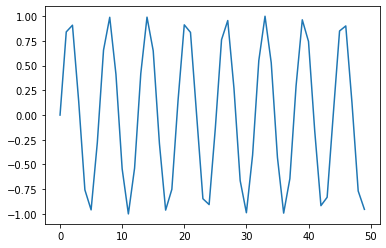

In [3]:
plt.plot(sin_wave[:50])

In [4]:
len(sin_wave), sin_wave.shape

(200, (200,))

### Guardamos algunos intervalos de tiempo X(t)

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len #150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X[i], Y[i]))
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

it: 0 | X:[ 0.          0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427
 -0.2794155   0.6569866   0.98935825  0.41211849 -0.54402111 -0.99999021
 -0.53657292  0.42016704  0.99060736  0.65028784 -0.28790332 -0.96139749
 -0.75098725  0.14987721  0.91294525  0.83665564 -0.00885131 -0.8462204
 -0.90557836 -0.13235175  0.76255845  0.95637593  0.27090579 -0.66363388
 -0.98803162 -0.40403765  0.55142668  0.99991186  0.52908269 -0.42818267
 -0.99177885 -0.64353813  0.29636858  0.96379539  0.74511316 -0.15862267
 -0.91652155 -0.83177474  0.01770193  0.85090352  0.90178835  0.12357312
 -0.76825466 -0.95375265] | Y:-0.26237485370392877
it: 1 | X:[ 0.84147098  0.90929743  0.14112001 -0.7568025  -0.95892427 -0.2794155
  0.6569866   0.98935825  0.41211849 -0.54402111 -0.99999021 -0.53657292
  0.42016704  0.99060736  0.65028784 -0.28790332 -0.96139749 -0.75098725
  0.14987721  0.91294525  0.83665564 -0.00885131 -0.8462204  -0.90557836
 -0.13235175  0.76255845  0.95637593  0.27090579 -0.663

In [6]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

### Creamos un conjunto de validación

In [7]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X_val[i-100], Y_val[i-100]))
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

it: 100 | X:[-0.50636564  0.45202579  0.99482679  0.62298863 -0.3216224  -0.97053528
 -0.7271425   0.18478174  0.92681851  0.81674261 -0.04424268 -0.86455145
 -0.8899956  -0.09718191  0.78498039  0.94543533  0.23666139 -0.68969794
 -0.98195217 -0.3714041   0.58061118  0.99881522  0.49871315 -0.45990349
 -0.99568699 -0.61604046  0.32999083  0.97263007  0.72103771 -0.19347339
 -0.93010595 -0.81160339  0.05308359  0.86896576  0.88592482  0.08836869
 -0.79043321 -0.94251445 -0.22805226  0.69608013  0.98023966  0.36317137
 -0.58779501 -0.99834536 -0.49102159  0.46774516  0.99646917  0.60904402
 -0.33833339 -0.97464865] | Y:-0.7148764296291646
it: 101 | X:[ 0.45202579  0.99482679  0.62298863 -0.3216224  -0.97053528 -0.7271425
  0.18478174  0.92681851  0.81674261 -0.04424268 -0.86455145 -0.8899956
 -0.09718191  0.78498039  0.94543533  0.23666139 -0.68969794 -0.98195217
 -0.3714041   0.58061118  0.99881522  0.49871315 -0.45990349 -0.99568699
 -0.61604046  0.32999083  0.97263007  0.72103771 -0.

## Arquitectura de la RNN

In [8]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # largo de la secuencia
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Matrices de Pesos:

 - U es la matriz de pesos para los pesos entre la entrada y las capas ocultas.
 - V es la matriz de epsos para los pesos entre las capas ocultas y las de salida.
 - W es la matriz de pesos para los pesos compartidos en la capa oculta, la capa recurrente propia de las RNNs.

In [9]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

### Función de activación:

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Entrenamiento

In [11]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[110601.33521133]] , Val Loss:  [[55298.81387924]]
Epoch:  2 , Loss:  [[68574.4477394]] , Val Loss:  [[34285.75591734]]
Epoch:  3 , Loss:  [[36547.56026741]] , Val Loss:  [[18272.69795541]]
Epoch:  4 , Loss:  [[14520.67224308]] , Val Loss:  [[7259.63971709]]
Epoch:  5 , Loss:  [[2491.1883269]] , Val Loss:  [[1245.2828013]]
Epoch:  6 , Loss:  [[23.61882997]] , Val Loss:  [[11.77498817]]
Epoch:  7 , Loss:  [[17.06825176]] , Val Loss:  [[8.51785514]]
Epoch:  8 , Loss:  [[17.67865931]] , Val Loss:  [[8.82031051]]
Epoch:  9 , Loss:  [[17.05722938]] , Val Loss:  [[8.51239028]]
Epoch:  10 , Loss:  [[17.24915974]] , Val Loss:  [[8.60662092]]
Epoch:  11 , Loss:  [[17.18071632]] , Val Loss:  [[8.57463051]]
Epoch:  12 , Loss:  [[17.25267217]] , Val Loss:  [[8.60804536]]
Epoch:  13 , Loss:  [[16.95921068]] , Val Loss:  [[8.46460795]]
Epoch:  14 , Loss:  [[17.18980313]] , Val Loss:  [[8.58107173]]
Epoch:  15 , Loss:  [[17.17020103]] , Val Loss:  [[8.56889602]]
Epoch:  16 , Loss:

In [12]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

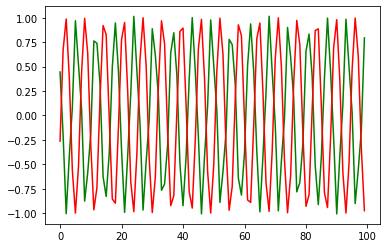

In [13]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Ahora en el conjunto de validación

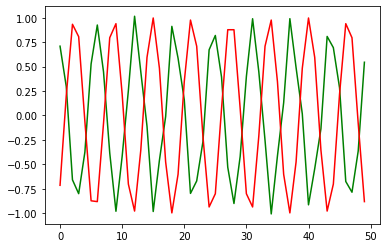

In [14]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_val[:, 0], preds[:, 0, 0])

1.6837708526897897

### Comparando con una red MLP de tensorflow

In [16]:
import tensorflow.keras as K

In [37]:
numNeurons = 100
model = K.models.Sequential([
    K.layers.Dense(numNeurons, activation='relu', input_shape=(50,)),
    K.layers.Dense(1, activation='linear')
    # 
    
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               5100      
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(X[:,:,0],
                    Y,
                    validation_data=(X_val[:,:,0],
                                     Y_val),
                    epochs=20, batch_size=16)  

Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.3493 - val_loss: 0.0232
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0815 - val_loss: 0.1109
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0062
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0306
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.0016
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0073
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 8.1494e-04
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 9.6462e-04 - val_loss: 3.6130e-04
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 7.3732e-04 - val_loss: 4.0225e-04
Epoch 11/20
7/7 [=

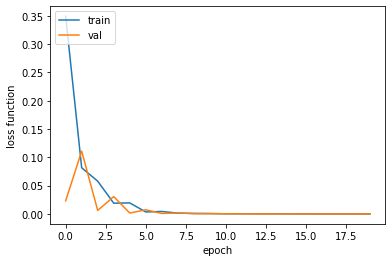

In [39]:
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
# plt.title('model loss function: {:.3} min'.format(timef))
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [48]:
preds = model.predict(X_val[:,:,0])
preds.shape, Y_val.shape, X_val[:,:,0].shape

2/2 [==============================] - 0s 1ms/step


((50, 1), (50, 1), (50, 50))

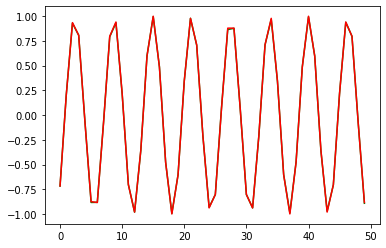

In [52]:
plt.plot(preds, 'g')
plt.plot(Y_val, 'r')
plt.show()